In [1]:
'''
%%writefile ns.py
start = time.time()
end = time.time()
print(end-start)
'''
import tensorflow as tf
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import os as os
import sys
from pathlib import Path
import sklearn as sk 
import time
import scipy.stats as stats
from sklearn.preprocessing.data import QuantileTransformer
from tensorflow.keras import regularizers

mhsdir = Path(os.getcwd()).parent
sys.path.append(os.path.join(mhsdir, 'src'))

import ns

datarawdir = os.path.join(mhsdir, 'data\\raw\\YC')
dataprepdir = os.path.join(mhsdir, 'data\\preprocessed')
dataprepnsdir = os.path.join(mhsdir, 'data\\preprocessed\\ns')
modeldir = os.path.join(mhsdir, 'models')

repodir = repodir = os.path.join(mhsdir, 'data\\train\\repository')
traindir = os.path.join(repodir, 'train')
testdir = os.path.join(repodir, 'test')

tfk = tf.keras
tfkl = tf.keras.layers

In C:\Users\PLDD\Anaconda3\envs\tf\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\PLDD\Anaconda3\envs\tf\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\PLDD\Anaconda3\envs\tf\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\PLDD\Anaconda3\envs\tf\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\PLDD\Anaconda3\envs\tf\lib\site-packages\matplotlib\

# Final preprocessing

In [3]:
df = None

for filename in os.listdir(traindir):
    print(filename)
    path=os.path.join(traindir, filename)
    df1 = pd.read_csv(path, sep = ';', header = None)
    if df is None:
        df = df1
        continue
    df = pd.concat([df, df1])
train_df = df.iloc[:,:-1]
test1_df = pd.read_csv(os.path.join(testdir, "train_real.txt"), sep = ';', header = None).iloc[:,:-1]
test21_df = pd.read_csv(os.path.join(testdir, "test2_5084.txt"), sep = ';', header = None).iloc[:,:-1]
test22_df = pd.read_csv(os.path.join(testdir, "test2_72168.txt"), sep = ';', header = None).iloc[:,:-1]
test2_df = pd.concat([test21_df, test22_df])

print("train - {}, test1 - {}, test2 - {}".format(train_df.shape[0], test1_df.shape[0], test2_df.shape[0]))
train_df = train_df.drop_duplicates(subset = [0,1])
test2_df = test2_df.drop_duplicates(subset = [0,1])

print("train - {}, test1 - {}, test2 - {}".format(train_df.shape[0], test1_df.shape[0], test2_df.shape[0]))
lx = (test1_df.iloc[:,-14:-2] < -0.00001).any(axis = 1)
test1_df = test1_df[~lx]
print("test1 - {}".format(lx.sum()))

lx = (test2_df.iloc[:,-14:-2] < -0.00001).any(axis = 1)
test2_df = test2_df[~lx]
print("test2 - {}".format(lx.sum()))

lx = (train_df.iloc[:,-14:-2] < -0.00001).any(axis = 1)
train_df = train_df[~lx]
print("train - {}".format(lx.sum()))

print("train - {}, test1 - {}, test2 - {}".format(train_df.shape[0], test1_df.shape[0], test2_df.shape[0]))

for i in range(100):
    train_df = train_df.sample(frac = 1).reset_index(drop=True)

trainfilepath = os.path.join(repodir, 'train_{}'.format(train_df.shape[0]) )
train_df.to_csv(trainfilepath,index = False)

testfilepath1 = os.path.join(repodir, 'test_{}'.format(test1_df.shape[0]) )
test1_df.to_csv(testfilepath1,index = False)

testfilepath2 = os.path.join(repodir, 'test_{}'.format(test2_df.shape[0]) )
test2_df.to_csv(testfilepath2,index = False)

train_real_0_0_410_38_40938.txt
train_real_1600_0_46363.txt
train_real_1600_0_58256.txt
train_real_1600_0_61440.txt
train_real_1600_0_61657.txt
train_real_1600_0_67635.txt
train_real_410_0_9132.txt
train - 345421, test1 - 102230, test2 - 77252
train - 345420, test1 - 102230, test2 - 77252
test1 - 1
test2 - 0
train - 21764
train - 323656, test1 - 102229, test2 - 77252


# Train and build model

In [4]:
def to_category(freqv): 
    res = np.zeros((freqv.shape[0],12))
    for i in range(freqv.shape[0]):
        if freqv[i] == 1:
            res[i] = np.array([1,1,1,1,1,1,1,1,1,1,1,1],dtype = 'float')
        elif freqv[i] == 2:
            res[i] = np.array([0,1,0,1,0,1,0,1,0,1,0,1],dtype = 'float') 
        elif freqv[i] == 3:
            res[i] = np.array([0,0,1,0,0,1,0,0,1,0,0,1],dtype = 'float')
        elif freqv[i] == 4:
            res[i] = np.array([0,0,0,1,0,0,0,1,0,0,0,1],dtype = 'float')
        elif freqv[i] == 6:
            res[i] = np.array([0,0,0,0,0,1,0,0,0,0,0,1],dtype = 'float')
        elif freqv[i] == 12:
            res[i] = np.array([0,0,0,0,0,0,0,0,0,0,0,1],dtype = 'float')
    return res

def convertor(df):
    df.columns = ['n','id','bmode','tb1','tb2','tb3','tb4','tb5','tb6','tb7','tb8','tb9','tb10','tb11','tb12','tb13','tb14','tb15','tb16','tb17','tb18','tb19','tb20','tb21',
           'ts1','ts2','ts3','ts4','ts5','ts6','ts7','ts8','ts9','ts10','ts11','ts12','ts13','ts14','ts15','ts16','ts17','ts18','ts19','ts20','ts21',
           't1','t2','t3','t4','t5','t6','t7','t8','t9','t10','t11','t12','t13','t14','t15','t16','t17','t18','t19','t20','t21',
           'c1','c2','c3','c4','c5','c6','c7','c8','c9','c10','c11','c12','smode','freq']
    act_columns = ['tb1','tb2','tb3','tb4','tb5','tb6','tb7','tb8','tb9','tb10','tb11','tb12','tb13','tb14','tb15','tb16','tb17','tb18','tb19','tb20','tb21',
               'ts1','ts2','ts3','ts4','ts5','ts6','ts7','ts8','ts9','ts10','ts11','ts12','ts13','ts14','ts15','ts16','ts17','ts18','ts19','ts20','ts21',
               'c1','c2','c3','c4','c5','c6','c7','c8','c9','c10','c11','c12']
    coup_columns = ['c1','c2','c3','c4','c5','c6','c7','c8','c9','c10','c11','c12'] 
    target = df[coup_columns].sum(axis=1)
    data = df[act_columns].copy()
    data.loc[:,coup_columns] = to_category(df['freq'])
    return data,target

def VaR(ar):
    sar = np.sort(ar)
    sz = sar.shape[0]
    rsk = np.rint(sz * (1 - np.array([0.99,0.98,0.97,0.96,0.95,0.94,0.93,0.92,0.91,0.9]))).astype('int')
    return sar[rsk]

In [5]:
train_df = pd.read_csv(trainfilepath)
test1_df = pd.read_csv(testfilepath1)
test2_df = pd.read_csv(testfilepath2)
train_data, train_target = convertor(train_df)
test1_data, test1_target = convertor(test1_df)
test2_data, test2_target = convertor(test2_df)

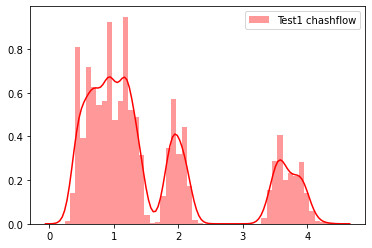

In [6]:
sn.distplot(test2_target,label = 'Test1 chashflow', color = 'r')
#sn.distplot(test2_target,label = 'Test2 chashflow')
#sn.distplot(train_target,label = 'Train chashflow')
plt.legend()

In [7]:
train_data.keys().shape

(54,)

In [8]:
model = tf.keras.Sequential([
                    tf.keras.layers.Dense(128, activation='relu',input_shape = [len(train_data.keys())]),
                    tf.keras.layers.Dense(128, activation='relu'),
                    tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l1(0.0001)),
                    tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l1(0.0001)), 
                    tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l1(0.0001)), 
                    tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l1(0.0001)), 
                    tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l1(0.0001)), 
                    #tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l1(0.0001)), 
                    #tf.keras.layers.Dense(64, activation='relu'),
                    #tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l1(l=0.00001)),                 
                    #tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l1(l=0.0001)),
                    tf.keras.layers.Dense(1)       
])
model.compile(loss = 'mse',
              optimizer = tf.keras.optimizers.Adagrad(0.001),
              metrics = ['mae','mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               7040      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 128)               1

In [9]:
EPOCHS = 256 
history = model.fit(
  train_data, train_target,
  batch_size = 64,
  epochs=EPOCHS, validation_data=(test1_data,test1_target))

Epoch 1/256
5058/5058 [==============================] - 19s 4ms/step - loss: 0.8271 - mae: 0.2287 - mse: 0.2034 - val_loss: 0.6496 - val_mae: 0.1437 - val_mse: 0.0302
Epoch 2/256
5058/5058 [==============================] - 18s 4ms/step - loss: 0.6569 - mae: 0.1284 - mse: 0.0414 - val_loss: 0.6331 - val_mae: 0.1221 - val_mse: 0.0216
Epoch 3/256
5058/5058 [==============================] - 18s 4ms/step - loss: 0.6376 - mae: 0.1085 - mse: 0.0298 - val_loss: 0.6195 - val_mae: 0.1028 - val_mse: 0.0155
Epoch 4/256
5058/5058 [==============================] - 18s 4ms/step - loss: 0.6239 - mae: 0.0958 - mse: 0.0237 - val_loss: 0.6102 - val_mae: 0.0966 - val_mse: 0.0138
Epoch 5/256
5058/5058 [==============================] - 19s 4ms/step - loss: 0.6125 - mae: 0.0870 - mse: 0.0197 - val_loss: 0.5995 - val_mae: 0.0804 - val_mse: 0.0104
Epoch 6/256
5058/5058 [==============================] - 18s 4ms/step - loss: 0.6025 - mae: 0.0805 - mse: 0.0170 - val_loss: 0.5891 - val_mae: 0.0648 - val_mse:

5058/5058 [==============================] - 16s 3ms/step - loss: 0.3547 - mae: 0.0380 - mse: 0.0038 - val_loss: 0.3526 - val_mae: 0.0451 - val_mse: 0.0036
Epoch 50/256
5058/5058 [==============================] - 18s 4ms/step - loss: 0.3508 - mae: 0.0378 - mse: 0.0038 - val_loss: 0.3487 - val_mae: 0.0447 - val_mse: 0.0035
Epoch 51/256
5058/5058 [==============================] - 18s 4ms/step - loss: 0.3470 - mae: 0.0376 - mse: 0.0037 - val_loss: 0.3447 - val_mae: 0.0441 - val_mse: 0.0034
Epoch 52/256
5058/5058 [==============================] - 18s 4ms/step - loss: 0.3432 - mae: 0.0374 - mse: 0.0037 - val_loss: 0.3411 - val_mae: 0.0444 - val_mse: 0.0035
Epoch 53/256
5058/5058 [==============================] - 18s 4ms/step - loss: 0.3395 - mae: 0.0372 - mse: 0.0037 - val_loss: 0.3373 - val_mae: 0.0436 - val_mse: 0.0033
Epoch 54/256
5058/5058 [==============================] - 18s 4ms/step - loss: 0.3358 - mae: 0.0370 - mse: 0.0036 - val_loss: 0.3338 - val_mae: 0.0439 - val_mse: 0.0034

5058/5058 [==============================] - 18s 4ms/step - loss: 0.2380 - mae: 0.0322 - mse: 0.0028 - val_loss: 0.2376 - val_mae: 0.0410 - val_mse: 0.0029
Epoch 98/256
5058/5058 [==============================] - 19s 4ms/step - loss: 0.2370 - mae: 0.0321 - mse: 0.0028 - val_loss: 0.2368 - val_mae: 0.0416 - val_mse: 0.0030
Epoch 99/256
5058/5058 [==============================] - 18s 4ms/step - loss: 0.2361 - mae: 0.0321 - mse: 0.0028 - val_loss: 0.2357 - val_mae: 0.0405 - val_mse: 0.0029
Epoch 100/256
5058/5058 [==============================] - 18s 4ms/step - loss: 0.2352 - mae: 0.0320 - mse: 0.0028 - val_loss: 0.2350 - val_mae: 0.0412 - val_mse: 0.0030
Epoch 101/256
5058/5058 [==============================] - 19s 4ms/step - loss: 0.2343 - mae: 0.0319 - mse: 0.0028 - val_loss: 0.2340 - val_mae: 0.0407 - val_mse: 0.0029
Epoch 102/256
5058/5058 [==============================] - 18s 4ms/step - loss: 0.2334 - mae: 0.0318 - mse: 0.0027 - val_loss: 0.2334 - val_mae: 0.0421 - val_mse: 0.0

5058/5058 [==============================] - 19s 4ms/step - loss: 0.2047 - mae: 0.0293 - mse: 0.0023 - val_loss: 0.2050 - val_mae: 0.0405 - val_mse: 0.0029
Epoch 146/256
5058/5058 [==============================] - 19s 4ms/step - loss: 0.2042 - mae: 0.0292 - mse: 0.0023 - val_loss: 0.2044 - val_mae: 0.0404 - val_mse: 0.0028
Epoch 147/256
5058/5058 [==============================] - 19s 4ms/step - loss: 0.2036 - mae: 0.0292 - mse: 0.0023 - val_loss: 0.2037 - val_mae: 0.0391 - val_mse: 0.0027
Epoch 148/256
5058/5058 [==============================] - 19s 4ms/step - loss: 0.2031 - mae: 0.0291 - mse: 0.0023 - val_loss: 0.2032 - val_mae: 0.0390 - val_mse: 0.0026
Epoch 149/256
5058/5058 [==============================] - 19s 4ms/step - loss: 0.2026 - mae: 0.0291 - mse: 0.0023 - val_loss: 0.2028 - val_mae: 0.0399 - val_mse: 0.0028
Epoch 150/256
5058/5058 [==============================] - 19s 4ms/step - loss: 0.2021 - mae: 0.0291 - mse: 0.0023 - val_loss: 0.2024 - val_mae: 0.0410 - val_mse: 0

5058/5058 [==============================] - 17s 3ms/step - loss: 0.1829 - mae: 0.0274 - mse: 0.0021 - val_loss: 0.1832 - val_mae: 0.0387 - val_mse: 0.0026
Epoch 194/256
5058/5058 [==============================] - 17s 3ms/step - loss: 0.1825 - mae: 0.0274 - mse: 0.0021 - val_loss: 0.1829 - val_mae: 0.0396 - val_mse: 0.0027
Epoch 195/256
5058/5058 [==============================] - 18s 4ms/step - loss: 0.1821 - mae: 0.0273 - mse: 0.0021 - val_loss: 0.1826 - val_mae: 0.0398 - val_mse: 0.0027
Epoch 196/256
5058/5058 [==============================] - 18s 4ms/step - loss: 0.1817 - mae: 0.0273 - mse: 0.0021 - val_loss: 0.1821 - val_mae: 0.0388 - val_mse: 0.0026
Epoch 197/256
5058/5058 [==============================] - 18s 4ms/step - loss: 0.1814 - mae: 0.0273 - mse: 0.0021 - val_loss: 0.1822 - val_mae: 0.0423 - val_mse: 0.0031
Epoch 198/256
5058/5058 [==============================] - 17s 3ms/step - loss: 0.1810 - mae: 0.0273 - mse: 0.0021 - val_loss: 0.1813 - val_mae: 0.0387 - val_mse: 0

5058/5058 [==============================] - 18s 3ms/step - loss: 0.1664 - mae: 0.0260 - mse: 0.0019 - val_loss: 0.1669 - val_mae: 0.0391 - val_mse: 0.0026
Epoch 242/256
5058/5058 [==============================] - 17s 3ms/step - loss: 0.1661 - mae: 0.0260 - mse: 0.0019 - val_loss: 0.1666 - val_mae: 0.0392 - val_mse: 0.0026
Epoch 243/256
5058/5058 [==============================] - 17s 3ms/step - loss: 0.1658 - mae: 0.0259 - mse: 0.0019 - val_loss: 0.1663 - val_mae: 0.0391 - val_mse: 0.0026
Epoch 244/256
5058/5058 [==============================] - 18s 3ms/step - loss: 0.1654 - mae: 0.0260 - mse: 0.0019 - val_loss: 0.1660 - val_mae: 0.0391 - val_mse: 0.0026
Epoch 245/256
5058/5058 [==============================] - 18s 3ms/step - loss: 0.1651 - mae: 0.0259 - mse: 0.0019 - val_loss: 0.1656 - val_mae: 0.0385 - val_mse: 0.0025
Epoch 246/256
5058/5058 [==============================] - 18s 4ms/step - loss: 0.1648 - mae: 0.0259 - mse: 0.0019 - val_loss: 0.1654 - val_mae: 0.0391 - val_mse: 0

In [9]:
version = 2
export_path = os.path.join(modeldir, str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')

export_path = C:\Users\PLDD\Practice\GitHub\Python\MHS\models\2

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:\Users\PLDD\Practice\GitHub\Python\MHS\models\2\assets

Saved model:


In [10]:
y_act1 = test1_target.to_numpy()
y_pred1 = model.predict(test1_data).reshape(-1)
dff1 = pd.DataFrame({'True': y_act1, 'Predicted' : y_pred1})
dff1.describe()

,True,Predicted
count,102229.000000,102229.000000
mean,2.119526,2.099114
std,1.353206,1.335655
min,0.322815,0.296175
25%,1.168864,1.139747
50%,1.603277,1.599841
75%,2.647212,2.591331
max,8.725821,8.085433


In [11]:
dff1 = pd.DataFrame({'True': y_act1, 'Predicted' : y_pred1, 'RelAbsError' : np.abs(y_act1 - y_pred1) / y_act1 })
dff1.head(40)

,True,Predicted,RelAbsError
0,1.185371,1.124393,0.051443
1,2.732201,2.640882,0.033423
2,1.847034,1.831631,0.008339
3,5.093862,5.047016,0.009197
4,1.578469,1.554964,0.014891
5,0.803531,0.805176,0.002048
6,1.856498,1.878522,0.011863
7,1.175795,1.160202,0.013262
8,2.770445,2.793549,0.008340
9,4.630065,4.558589,0.015437


In [53]:
y_act2 = test2_target.to_numpy()
y_pred2 = model.predict(test2_data).reshape(-1)
dff2 = pd.DataFrame({'Act': test2_target, 'Pred' : y_pred2})
dff2.describe()

,Act,Pred
count,77252.000000,77252.000000
mean,1.552110,1.583608
std,1.072593,1.121669
min,0.236809,0.260663
25%,0.766257,0.748884
50%,1.168075,1.163603
75%,1.960509,2.036124
max,4.360890,4.469329


In [54]:
dff2 = pd.DataFrame({'True': y_act2, 'Predicted' : y_pred2, 'RelAbsError' : np.abs(y_act2 - y_pred2) / y_act2 })
dff2.head(40)

,True,Predicted,RelAbsError
0,3.629713,3.677676,0.013214
1,2.023284,2.031945,0.004280
2,2.086750,2.051767,0.016765
3,2.094966,2.061333,0.016054
4,0.763410,0.877692,0.149700
5,0.485389,0.565386,0.164810
6,3.627695,3.680243,0.014485
7,1.041565,1.076898,0.033923
8,0.482382,0.564079,0.169362
9,0.482382,0.564104,0.169414


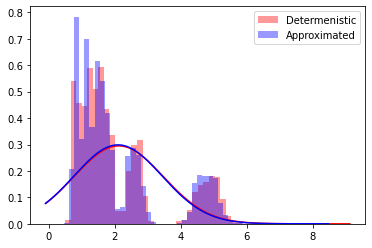

In [12]:
sn.distplot(y_act1,fit = stats.norm, color = 'red', label = 'Determenistic',fit_kws={"color":"red"},kde = False)
sn.distplot(y_pred1, fit = stats.norm, color = 'blue', label = 'Approximated',fit_kws={"color":"blue"},kde=False)
plt.legend()

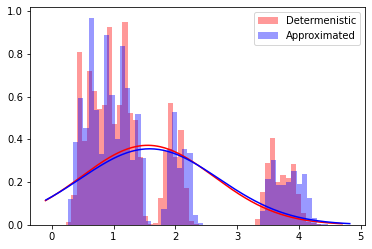

In [56]:
sn.distplot(y_act2,fit = stats.norm, color = 'red', label = 'Determenistic',fit_kws={"color":"red"},kde = False)
sn.distplot(y_pred2, fit = stats.norm, color = 'blue', label = 'Approximated',fit_kws={"color":"blue"},kde=False)
plt.legend()

export_path = C:\Users\PLDD\Practice\GitHub\Python\MHS\models\1

INFO:tensorflow:Assets written to: C:\Users\PLDD\Practice\GitHub\Python\MHS\models\1\assets

Saved model:


In [17]:
path = os.path.join(repodir,"train3.txt")
t_df = pd.read_csv(path, sep = ';', header = None)

print("train - {}".format(t_df.shape[0]))
t_df = t_df.drop_duplicates(subset = [0,1])

print("train - {}".format(t_df.shape[0]))

lx = (t_df.iloc[:,-13:-1] < -0.00001).any(axis = 1)
t_df = t_df[~lx]
print("train - {}".format(lx.sum()))

print("train - {}".format(t_df.shape[0]))



train - 260491
train - 260490
train - 963
train - 259527


In [28]:
dfff = t_df
df1 = (np.abs(dfff.iloc[:,2:23]) > 0.000000001).astype('float')
df2 = (np.abs(dfff.iloc[:,-12:]) > 0.000000001).astype('float')
df3 = dfff.iloc[:,2:23]
df4 = dfff.iloc[:,23:44]
df5 = dfff.iloc[:,44:65]
df6 = dfff.iloc[:,65:]
xx = pd.concat([df3, df4, df2], axis = 1).to_numpy()
yy = df6.sum(axis = 1).to_numpy()

lx = (yy >= 0.001) & (yy <=100.0)

xx = xx[lx]
yy = yy[lx]

i0 = 200000
t_x = xx[:i0,:]
t_y = yy[:i0]
ts_x = xx[i0:,:]
ts_y = yy[i0:]

In [35]:
ts_y.shape

(59518,)

In [34]:
y_pred11.shape

(59518,)

In [36]:
y_act11 = ts_y
y_pred11 = model.predict(ts_x).reshape(-1)
dff11 = pd.DataFrame({'Act': y_act11, 'Pred' : y_pred11})
dff11.describe()

,Act,Pred
count,59518.000000,59518.000000
mean,7.929100,2.352154
std,8.857059,1.876920
min,0.469519,-2.077293
25%,1.989540,1.065814
50%,4.770917,1.753205
75%,10.283777,3.114681
max,97.510054,25.389151


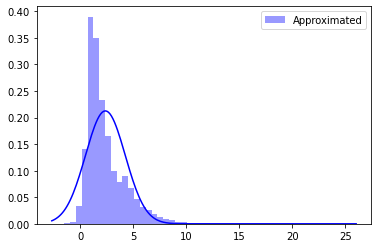

In [57]:
#sn.distplot(y_act11,fit = stats.norm, color = 'red', label = 'Determenistic',fit_kws={"color":"red"},kde = False)
sn.distplot(y_pred11, fit = stats.norm, color = 'blue', label = 'Approximated',fit_kws={"color":"blue"},kde=False)
plt.legend()

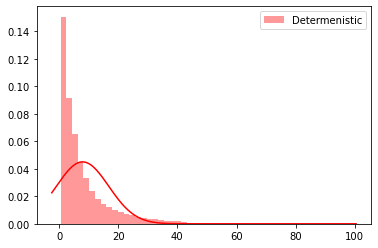

In [58]:
sn.distplot(y_act11,fit = stats.norm, color = 'red', label = 'Determenistic',fit_kws={"color":"red"},kde = False)
#sn.distplot(y_pred11, fit = stats.norm, color = 'blue', label = 'Approximated',fit_kws={"color":"blue"},kde=False)
plt.legend()